In [1]:
#!pip install yfinance

# Stock Portfolio Optimization - Exploratory Data Analysis (EDA)
## Problem Statement

Portfolio Optimization problem is an *Optimization Problem* that tries to decide how much of an investor’s wealth 
should be invested in each of the assets in order to reach the Objective:
- Maximizing Conditional Sharpe Ratio 

We will explore this objective to find an optimal solution.

We will deal with a set of portfolio templates and identfy which portfolio wins for the basic Portfolio Optimization problem stated above.

## Important Notes
Though other options may be available and working in this Jupyter notebook, but for the current submission the following options should be set for proper functioning of the notebook:
- NUM_SIMS = 100_000 (minimum)
- DEBUG = False


# Data Sources

### Yahoo Finance
yfinance uses Yahoo's publicaly available API for making market data available. In this notebook, we are using yfinance python library for accessing historical stock price data.

Oficial documentation of the yfinance Python package is available here:
https://pypi.org/project/yfinance/

Frequency: Daily


In [2]:
# import libraries
import pathlib
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from dateutil import rrule
import locale

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from scipy import stats
from scipy.stats.mstats import gmean, normaltest

# Pandas display settings
plt.style.use('seaborn') 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

%matplotlib inline
%config InlineBackend.figure_firmat = 'retina'


## Time Window for Stock Price data
Our initial target is to use past ten years of stock price data. Later we will revise this window depending on availability of stock price data.

We will see later that START_DATE could be set to the beginning of year 2016.


# Source of Sample Portfolio Data
Starter Portfolio is taken from: 
https://money.usnews.com/investing/stock-market-news/articles/best-stocks-for-a-starter-portfolio

Remaining four portfolios are taken from 
7 Diversified Stock Portfolio Examples For Beginners
https://www.wallstreetzen.com/blog/example-stock-portfolios/

# List of Portfolios

## Starter Portfolio
- Berkshire Hathaway Inc. (NYSE: BRK-B)
- Apple Inc. (NASDAQ: AAPL)
- Microsoft Corp. (NASDAQ: MSFT)
- Alphabet Inc. (NASDAQ: GOOGL)
- Coca-Cola Co. (NYSE: KO)
- Costco Wholesale Corp. (NASDAQ: COST)
- Pfizer Inc. (NYSE: PFE)
- AT&T Inc. (NYSE: T)
- NextEra Energy Inc. (NYSE: NEE)

## Large Cap Blue-Chips Portfolio
- Apple Inc. (NASDAQ: AAPL)
- Berkshire Hathaway Inc. (NYSE: BRK-B)
- Alphabet Inc. (NASDAQ: GOOGL)
- Microsoft Corp. (NASDAQ: MSFT)
- McDonald’s Corp. (NYSE: MCD)
- Costco Wholesale Corp. (NASDAQ: COST)
- Coca-Cola Co. (NYSE: KO)
- Verizon Communications Inc. (NYSE: VZ)

## Divident Portfolio
- Caterpillar Inc. (NYSE: CAT)        
- Chevron Corp. (NYSE: CVX)
- Johnson & Johnson (NYSE: JNJ)        
- Lowe’s Cos. Inc. (NYSE: LOW)
- McDonald’s Corp. (NYSE: MCD)
- PepsiCo Inc. (NASDAQ: PEP)
- Procter & Gamble Co. (NYSE: PG)        
- Target Corp. (NYSE: TGT)        
- Walgreens Boots Alliance Inc. (NASDAQ: WBA)        
- Walmart Inc. (NYSE: WMT)

## Value Portfolio
- Apple (NASDAQ: AAPL)
- Bank of America (NYSE: BAC)
- Coca-Cola (NYSE: KO)
- Chevron Corp. (NYSE: CVX)
- American Express (NYSE: AXP)
- Occidental Petroleum (NYSE: OXY)
- Moody’s (NYSE: MCO)
- US Bancorp (NYSE: USB)
- Activision Blizzard Inc (NASDAQ: ATVI)
- HP Inc (NYSE: HPE)

## Growth Portfolid
- Facebook (now Meta) (NASDAQ: META)
- Apple (NASDAQ: AAPL)
- Amazon (NASDAQ: AMZN)
- Netflix (NASDAQ: NFLX)
- Google (Alphabet) (NASDAQ: GOOGL)


## My Portfolio
This is my own portfolio reflecting my personal investment in individual stocks at the time of working on this Data Science project.
- Apple (NASDAQ: AAPL)
- Amazon (NASDAQ: AMZN)
- Google (Alphabet) (NASDAQ: GOOGL)
- The Goldman Sachs Group, Inc. (NYSE: GS)
- Johnson & Johnson (NYSE: JNJ) 
- Microsoft (NASDAQ: MSFT) 
- Pfizer Inc. (NYSE: PFE)

## S&P-500
It is a portfolio contining ETF with ticker symbol SPY only. This portfolio helps us in benchmarking portfolio optimization outcome.
- SPDR S&P 500 ETF Trust (NASDAQ: SPY)


In [3]:
# Define Global Constant values

# Start and end dates are assigned for capturing eight+ years of stock price history.
END_DATE = dt.datetime.now()
START_DATE = '2014-12-31'

NUM_SIMS = 100_000 # Number of times Monte Carlo Simulation to be run for each of the portfolios

DAYS_SIMS = 21 # Number of days Monte Carlo Simulation to be run

DEBUG = False # whether debug mode; in debug mode file names contain CODE_VERSION suffix

NUM_TRADE_DAYS = 252 # Number of trading days in a year

ALL_PORTFOLIOS_X = {
    # Growth Stock Portfolio
    'GROWTH': ['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX']
}

ALL_PORTFOLIOS = {
    # Starter Stock Portfolio
    'STARTER': ['AAPL', 'BRK-B', 'COST', 'GOOGL', 'KO', 'MSFT', 'NEE', 'PFE', 'T'],
    # Large Cap Blue-Chips Portfolio
    'LARGE CAPS': ['AAPL', 'BRK-B','COST', 'GOOGL', 'KO', 'MSFT', 'MCD', 'VZ'],
    # Dividend Stocks Portfolio
    'DIVIDEND': ['CAT', 'CVX', 'JNJ', 'LOW', 'MCD', 'PEP', 'PG', 'TGT', 'WBA', 'WMT'],
    # Value Stock Poprtfolio
    'VALUE': ['AAPL', 'BAC', 'KO', 'CVX', 'AXP', 'OXY', 'MCO', 'USB', 'ATVI', 'HPE'],  
    # Growth Stock Portfolio
    'GROWTH': ['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX'],
    # My own stock portfolio
    'MY PORTFOLIO': ['AAPL', 'AMZN', 'GOOGL', 'GS', 'JNJ', 'MSFT', 'PFE'],
    # SPY only - for benchmarking
    'S&P-500': ['SPY']
}

# Global variable assignment 
ONE_PORTFOLIO = 'GROWTH'
ONE_STOCK_TICKER = 'NFLX'

ALL_SYMBOLS = []
for portfolio_name, portfolio_symbols in ALL_PORTFOLIOS.items():
    for symbol in portfolio_symbols:
        if not(symbol in ALL_SYMBOLS):
            ALL_SYMBOLS.append(symbol)

# Seed is set to a fixed value to ensure reproducability of results between runs
SEED = 11
np.random.seed(SEED)

# Database name where prepared data is saved for later use
DB_NAME = 'mcmc.db'
ALL_DAILY_RETURNS_TABLE = 'all_daily_returns'


## Common Routines

In [4]:
def get_stock_price_data(symbols, 
                         start_date=START_DATE, 
                         end_date=END_DATE, 
                         columns=['Open', 'High', 'Low', 'Close', 'Adj Close']):
    """
    Function to get stock price data from Yahoo Finance
    input:
    Fwollowing are the input parameters for which stock price is to be fetched
    - tickers: list of ticker symbols
    - start-date: start date
    - end_date: end date
    - columns: list of columns to be fetched
    Output:
    - Dataframe to be returned
    """
    # Return the dataframe for ticker symbols and with selected columns
    return yf.download(symbols, start_date, end_date)[columns]


In [7]:
def read_csv_data(filename):
    """
    Reads csv file from a predefined sub-folder
    Input:
    - filename - name of the csv file to be read
    Output:
    - content of the input file in a data frame
    """
    df = pd.read_csv('Data/' + filename, parse_dates=['DATE'])
    
    return df


In [8]:
def get_missing_value_columns(df):
    """
    Function detect any missing values in the dataframe and returns a list of column names
    Input:
    - df - data frame
    Output:
    - nan_col_names - a list containg names of columns with missing values
    """
    # Get the number of missing values for each of the columns
    nan_col_counts = df.isna().sum()

    # Extract list of column names that has one or more missing vlaues
    nan_col_names = nan_col_counts[nan_col_counts > 0].index.tolist()

    # Return the list of column names that has missing values
    return nan_col_counts[nan_col_names]


In [9]:
def normalize_price(df):
    """
    Normalizes the data frame by dividing prices by the last entry
    Input:
    - df - dataframe containing stock prices
    Output:
    - Normalized prices
    """
    return df / df.iloc[0, :]


In [10]:
def get_moving_average(df, window):
    """
    Finds moving average of the stock prices 
    Input:
    - df - dataframe containing stock prices
    - window - rolling window size
    Output:
    - Mean prices
    """
    return df.rolling(window).mean()


In [11]:
def get_moving_std(df, window):
    """
    Finds moving standard deviation of the stock prices 
    Input:
    - df - dataframe containing stock prices
    - window - rolling window size
    Output:
    - Standard deviation of the stock prices
    """
    return df.rolling(window).std()


In [12]:
def get_bollinger_bands(df, window=20, num_of_std=2):
    """
    Returns Bollinger Bands(R) based on input dataframe
    Inputs:
    - df - dataframe containing stock price
    - window - number of days for the Bollinger Bands intervals
    - num_of_std - number of standard deviations for calculation of the uppper and lower band values
    Outputs:
    - moving_avg - simple moving average for the window
    - uppper_band - upper band value
    - lower_band - lower band value
    """
    moving_avg = get_moving_average(df, window)
    moving_std = get_moving_std(df, window)
    
    # Calculate upper and lower band values
    upper_band = moving_avg + moving_std * num_of_std
    lower_band = moving_avg - moving_std * num_of_std
    
    return moving_avg, upper_band, lower_band
    

# Exploratory Data Analysis

## Stock Price Data 
Stock Price data fetched using yfinance library. Data qulity check and data cleansing is primarily performed at this level.

In [13]:
# Get stock data
stock_price_df = get_stock_price_data(ALL_SYMBOLS,
                                      START_DATE, 
                                      END_DATE, 
                                      'Adj Close')

daily_return_df = stock_price_df.pct_change(periods = 1).dropna()
   

[*********************100%***********************]  32 of 32 completed


In [14]:
stock_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2086 entries, 2014-12-31 to 2023-04-14
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2086 non-null   float64
 1   AMZN    2086 non-null   float64
 2   ATVI    2086 non-null   float64
 3   AXP     2086 non-null   float64
 4   BAC     2086 non-null   float64
 5   BRK-B   2086 non-null   float64
 6   CAT     2086 non-null   float64
 7   COST    2086 non-null   float64
 8   CVX     2086 non-null   float64
 9   GOOGL   2086 non-null   float64
 10  GS      2086 non-null   float64
 11  HPE     1885 non-null   float64
 12  JNJ     2086 non-null   float64
 13  KO      2086 non-null   float64
 14  LOW     2086 non-null   float64
 15  MCD     2086 non-null   float64
 16  MCO     2086 non-null   float64
 17  META    2086 non-null   float64
 18  MSFT    2086 non-null   float64
 19  NEE     2086 non-null   float64
 20  NFLX    2086 non-null   float64
 21  OXY     2086 non-nu

In [15]:
# Look at the top sample values of the dataframe
stock_price_df.head(3)

,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31,24.801626,15.5175,19.074585,81.915497,15.258877,150.149994,72.336510,118.830406,78.661667,26.533001,166.911987,NaN,83.743065,32.408787,59.538288,75.668831,87.606400,78.019997,40.439583,21.637842,48.801430,60.655746,74.541138,21.902330,71.816963,176.883545,13.305531,60.484661,34.795589,31.375206,59.441917,71.941223
2015-01-02,24.565697,15.4260,19.055651,81.897911,15.267412,149.169998,72.613129,118.713058,78.942146,26.477501,167.411438,NaN,83.703003,32.347385,58.586365,75.313484,87.679550,78.449997,40.709465,21.719263,49.848572,60.685852,74.446541,22.028889,71.304504,176.788864,13.416445,60.022541,34.702686,31.495934,59.285904,71.957977
2015-01-05,23.873642,15.1095,18.790596,79.732048,14.823891,147.000000,68.780182,117.363380,75.786720,25.973000,162.184479,NaN,83.118423,32.347385,57.184444,74.481689,85.960533,77.190002,40.335106,21.489229,47.311428,58.436005,73.886887,21.909361,70.965485,173.596161,13.289688,58.946842,33.866665,31.234373,58.115791,71.748573


In [16]:
# Look at the bottom sample values of the dataframe
stock_price_df.tail(3)

,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-12,160.100006,97.830002,84.949997,159.289993,28.480000,314.549988,220.500000,489.350006,169.820007,104.639999,330.239990,15.980000,163.919998,62.689999,199.770004,285.299988,298.179993,214.000000,283.489990,78.589996,331.029999,64.839996,182.559998,41.369999,151.070007,408.049988,19.770000,163.509995,35.400002,39.200001,35.689999,149.339996
2023-04-13,165.559998,102.400002,85.580002,162.300003,28.559999,318.049988,221.669998,497.890015,172.089996,107.430000,332.130005,16.030001,166.110001,63.150002,201.470001,289.070007,303.899994,220.350006,289.839996,78.849998,346.190002,64.769997,184.380005,41.470001,151.770004,413.470001,19.959999,163.270004,35.380001,39.320000,35.779999,149.490005
2023-04-14,165.210007,102.510002,85.269997,163.220001,29.520000,319.739990,223.679993,491.299988,172.440002,108.870003,336.920013,15.910000,165.839996,63.049999,202.179993,288.980011,302.320007,221.490005,286.140015,78.019997,338.630005,64.480003,183.509995,41.189999,151.000000,412.459991,19.930000,161.000000,34.970001,39.220001,35.320000,148.479996


### Observations

#### Missing Stock Prices
We find missing values for the following stock:
- HPE

Apparetly this stock started trading few months after our start date (beginning of 2015). We will find additional details on this later.

#### Current Day Stock Prices Missing
We also notice that several stocks, including very popular stocks like AAPL, AMZN, GOOGL, JNJ, etc. have missing prices for the current trading day.


In [17]:
# Get the shape of the dataframe
stock_price_df.shape

(2086, 32)

#### Not Null Count Re-confirms Missing Price Data
Observations about missing stocks prices are re-confirmed from stock price structure. 

In [18]:
# Review structure of the dataframe
stock_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2086 entries, 2014-12-31 to 2023-04-14
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2086 non-null   float64
 1   AMZN    2086 non-null   float64
 2   ATVI    2086 non-null   float64
 3   AXP     2086 non-null   float64
 4   BAC     2086 non-null   float64
 5   BRK-B   2086 non-null   float64
 6   CAT     2086 non-null   float64
 7   COST    2086 non-null   float64
 8   CVX     2086 non-null   float64
 9   GOOGL   2086 non-null   float64
 10  GS      2086 non-null   float64
 11  HPE     1885 non-null   float64
 12  JNJ     2086 non-null   float64
 13  KO      2086 non-null   float64
 14  LOW     2086 non-null   float64
 15  MCD     2086 non-null   float64
 16  MCO     2086 non-null   float64
 17  META    2086 non-null   float64
 18  MSFT    2086 non-null   float64
 19  NEE     2086 non-null   float64
 20  NFLX    2086 non-null   float64
 21  OXY     2086 non-nu

### Review Statistical Properties
After reviewing statistical properties of stock price data we make no additional obervations.

In [19]:
# Review statistical properties of the dataframe
stock_price_df.describe()


,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
count,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,1885.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000
mean,73.925607,88.567981,58.974356,104.808503,25.627484,210.056074,130.651321,270.268347,97.388266,69.061170,228.049122,12.259698,124.961300,43.774444,117.348001,167.007942,197.471437,181.239367,142.394450,48.736209,288.684123,48.764458,115.526416,32.753142,99.299487,283.698532,17.553641,108.308257,42.179517,42.287381,53.024773,98.850561
std,50.648189,49.153641,20.577079,37.493264,9.055349,57.917648,55.288212,138.814039,29.395202,33.469071,74.556613,2.557845,28.870006,9.493732,56.182244,58.446983,92.706418,72.174737,90.623096,22.162284,159.655293,16.974669,31.448925,8.514420,31.086419,88.320528,1.950948,60.572391,7.210543,6.705674,12.044541,32.011543
min,20.883030,14.347500,17.559977,45.823326,9.634962,124.129997,48.072975,115.846672,47.194569,24.853001,122.750298,5.735403,74.265526,29.646326,55.899216,71.695595,72.671021,74.050003,35.172428,19.702932,45.547142,8.763958,71.660767,20.960419,54.922115,160.612961,13.165124,43.338257,25.423656,29.747046,29.770954,48.173405
25%,29.918376,41.766375,41.906182,71.870907,19.843374,163.762501,80.532063,145.800434,77.389915,41.480626,175.861092,10.849863,103.045076,35.819088,69.133663,108.343452,102.905603,127.055000,58.399517,27.325324,139.279999,37.767325,88.899067,25.610535,71.014912,204.207138,16.472672,61.896241,34.698123,36.655988,43.562130,67.486797
50%,48.407736,88.091999,60.546421,95.116936,25.745446,201.945000,122.713909,220.799652,92.458118,58.271751,202.850060,12.736924,121.877598,41.256990,92.833435,165.380142,170.977242,171.989998,108.029461,42.772184,293.184998,55.067417,103.848213,31.085123,89.517788,262.035446,17.767793,74.987392,42.804106,41.189556,52.862627,92.880890
75%,126.481510,124.092501,76.922070,136.232079,31.787424,255.255001,179.966789,366.078697,102.264200,92.195002,291.903786,14.130080,153.100407,50.876070,171.249546,215.185989,278.181679,209.187500,230.586220,71.406813,379.420006,60.202095,135.861740,36.150120,130.027363,371.249229,18.716174,156.516529,46.264868,48.731858,64.894131,132.543976
max,180.683868,186.570496,102.699326,194.931137,47.945423,359.570007,264.540009,603.873047,186.144424,149.838501,407.866791,16.985613,181.108810,64.306442,255.295242,289.070007,401.238342,382.179993,339.075562,90.823463,691.690002,75.595413,184.652191,58.783733,160.206589,468.296448,22.601288,259.244568,59.918385,54.233452,76.035652,157.359634


## Data Cleapup

In [20]:
# For each columns count the NaN values

print(f'\nColumns with missing prices:\n{get_missing_value_columns(stock_price_df)}')


Columns with missing prices:
HPE    201
dtype: int64


In [21]:
# Check NaN values for some stocks for the bottom record. 
stock_price_df.tail(3)

,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-12,160.100006,97.830002,84.949997,159.289993,28.480000,314.549988,220.500000,489.350006,169.820007,104.639999,330.239990,15.980000,163.919998,62.689999,199.770004,285.299988,298.179993,214.000000,283.489990,78.589996,331.029999,64.839996,182.559998,41.369999,151.070007,408.049988,19.770000,163.509995,35.400002,39.200001,35.689999,149.339996
2023-04-13,165.559998,102.400002,85.580002,162.300003,28.559999,318.049988,221.669998,497.890015,172.089996,107.430000,332.130005,16.030001,166.110001,63.150002,201.470001,289.070007,303.899994,220.350006,289.839996,78.849998,346.190002,64.769997,184.380005,41.470001,151.770004,413.470001,19.959999,163.270004,35.380001,39.320000,35.779999,149.490005
2023-04-14,165.210007,102.510002,85.269997,163.220001,29.520000,319.739990,223.679993,491.299988,172.440002,108.870003,336.920013,15.910000,165.839996,63.049999,202.179993,288.980011,302.320007,221.490005,286.140015,78.019997,338.630005,64.480003,183.509995,41.189999,151.000000,412.459991,19.930000,161.000000,34.970001,39.220001,35.320000,148.479996


## Data Cleansing Approach
### Stock Price Data Cleansing
There is exactly one ticker symbols (HPE) with missing data value, we will back fill and then forward fill these values.

All other stocks where only one value is missing is due to intraday missing price issue. We can confirm this by manually reviewing tail rows of the stock price dataframe (shown above).


In [22]:
# For the dataframe backfill the forward fill missing values
stock_price_df.backfill(inplace=True)
stock_price_df.ffill(inplace=True)


In [23]:
# Check for any missing values after cleansing
print(f'Columns with any missing values:\n{get_missing_value_columns(stock_price_df)}')


Columns with any missing values:
Series([], dtype: int64)


In [24]:
# Check that NaN column values have been backfilled
stock_price_df.head(3)


,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31,24.801626,15.5175,19.074585,81.915497,15.258877,150.149994,72.336510,118.830406,78.661667,26.533001,166.911987,7.842282,83.743065,32.408787,59.538288,75.668831,87.606400,78.019997,40.439583,21.637842,48.801430,60.655746,74.541138,21.902330,71.816963,176.883545,13.305531,60.484661,34.795589,31.375206,59.441917,71.941223
2015-01-02,24.565697,15.4260,19.055651,81.897911,15.267412,149.169998,72.613129,118.713058,78.942146,26.477501,167.411438,7.842282,83.703003,32.347385,58.586365,75.313484,87.679550,78.449997,40.709465,21.719263,49.848572,60.685852,74.446541,22.028889,71.304504,176.788864,13.416445,60.022541,34.702686,31.495934,59.285904,71.957977
2015-01-05,23.873642,15.1095,18.790596,79.732048,14.823891,147.000000,68.780182,117.363380,75.786720,25.973000,162.184479,7.842282,83.118423,32.347385,57.184444,74.481689,85.960533,77.190002,40.335106,21.489229,47.311428,58.436005,73.886887,21.909361,70.965485,173.596161,13.289688,58.946842,33.866665,31.234373,58.115791,71.748573


In [25]:
# Check that NaN column values have been forwardfilled
stock_price_df.tail(3)

,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-12,160.100006,97.830002,84.949997,159.289993,28.480000,314.549988,220.500000,489.350006,169.820007,104.639999,330.239990,15.980000,163.919998,62.689999,199.770004,285.299988,298.179993,214.000000,283.489990,78.589996,331.029999,64.839996,182.559998,41.369999,151.070007,408.049988,19.770000,163.509995,35.400002,39.200001,35.689999,149.339996
2023-04-13,165.559998,102.400002,85.580002,162.300003,28.559999,318.049988,221.669998,497.890015,172.089996,107.430000,332.130005,16.030001,166.110001,63.150002,201.470001,289.070007,303.899994,220.350006,289.839996,78.849998,346.190002,64.769997,184.380005,41.470001,151.770004,413.470001,19.959999,163.270004,35.380001,39.320000,35.779999,149.490005
2023-04-14,165.210007,102.510002,85.269997,163.220001,29.520000,319.739990,223.679993,491.299988,172.440002,108.870003,336.920013,15.910000,165.839996,63.049999,202.179993,288.980011,302.320007,221.490005,286.140015,78.019997,338.630005,64.480003,183.509995,41.189999,151.000000,412.459991,19.930000,161.000000,34.970001,39.220001,35.320000,148.479996


In [26]:
# Get dataframe stats one more time to ensure that all stocks have the same number of non-NaN values
stock_price_df.describe()


,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
count,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000
mean,73.925607,88.567981,58.974356,104.808503,25.627484,210.056074,130.651321,270.268347,97.388266,69.061170,228.049122,11.834051,124.961300,43.774444,117.348001,167.007942,197.471437,181.239367,142.394450,48.736209,288.684123,48.764458,115.526416,32.753142,99.299487,283.698532,17.553641,108.308257,42.179517,42.287381,53.024773,98.850561
std,50.648189,49.153641,20.577079,37.493264,9.055349,57.917648,55.288212,138.814039,29.395202,33.469071,74.556613,2.758940,28.870006,9.493732,56.182244,58.446983,92.706418,72.174737,90.623096,22.162284,159.655293,16.974669,31.448925,8.514420,31.086419,88.320528,1.950948,60.572391,7.210543,6.705674,12.044541,32.011543
min,20.883030,14.347500,17.559977,45.823326,9.634962,124.129997,48.072975,115.846672,47.194569,24.853001,122.750298,5.735403,74.265526,29.646326,55.899216,71.695595,72.671021,74.050003,35.172428,19.702932,45.547142,8.763958,71.660767,20.960419,54.922115,160.612961,13.165124,43.338257,25.423656,29.747046,29.770954,48.173405
25%,29.918376,41.766375,41.906182,71.870907,19.843374,163.762501,80.532063,145.800434,77.389915,41.480626,175.861092,9.155530,103.045076,35.819088,69.133663,108.343452,102.905603,127.055000,58.399517,27.325324,139.279999,37.767325,88.899067,25.610535,71.014912,204.207138,16.472672,61.896241,34.698123,36.655988,43.562130,67.486797
50%,48.407736,88.091999,60.546421,95.116936,25.745446,201.945000,122.713909,220.799652,92.458118,58.271751,202.850060,12.319315,121.877598,41.256990,92.833435,165.380142,170.977242,171.989998,108.029461,42.772184,293.184998,55.067417,103.848213,31.085123,89.517788,262.035446,17.767793,74.987392,42.804106,41.189556,52.862627,92.880890
75%,126.481510,124.092501,76.922070,136.232079,31.787424,255.255001,179.966789,366.078697,102.264200,92.195002,291.903786,14.017714,153.100407,50.876070,171.249546,215.185989,278.181679,209.187500,230.586220,71.406813,379.420006,60.202095,135.861740,36.150120,130.027363,371.249229,18.716174,156.516529,46.264868,48.731858,64.894131,132.543976
max,180.683868,186.570496,102.699326,194.931137,47.945423,359.570007,264.540009,603.873047,186.144424,149.838501,407.866791,16.985613,181.108810,64.306442,255.295242,289.070007,401.238342,382.179993,339.075562,90.823463,691.690002,75.595413,184.652191,58.783733,160.206589,468.296448,22.601288,259.244568,59.918385,54.233452,76.035652,157.359634


In [27]:
# Select one_stock from stock_price_df dataframe to be used for single stock plots
one_stock_returns = stock_price_df[ONE_STOCK_TICKER].pct_change(periods = 1).dropna(axis=0)


In [28]:
def plot_data(df, title, x_label, y_label=''):
    """
    Plot line graph for the dataframe
    Input:
    - df - dataframe to be plotted
    - title - title of the plot
    Output:
    - the plot
    """
    # Set plot size
    plt.figure(figsize=(12, 8), dpi=150)

    # For each ticker plot data
    for column in df.columns:
        df[column].plot(label=column)
    
    # Adding titles and X label to the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display legend and show
    plt.legend()
    plt.show();
    

In [29]:
# Plot Bollinger bands
def plot_bollinger_bands(ticker, start_date=START_DATE, end_date=END_DATE):
    """
    Plot Bollinger Bands for a ticker symbol
    Inputs:
    - ticker - ticker symbol for which Bollinger Bands are to be plotted
    - start_date - start_date of the Bollinger Bands to be plotted
    - end_date - end date of the Bollinger Bands to be plotted
    """
    data_start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
    data_start_date = data_start_date.date() - dt.timedelta(days=90)
    stock_price_daily = stock_price_df[data_start_date:end_date][ticker]
    moving_avg, upper_band, lower_band = get_bollinger_bands(stock_price_daily)
    
    # Construct Bollinger Band data
    boll_band_df = pd.DataFrame({'Upper Band': upper_band[start_date:end_date], 
                       'Daily Price': stock_price_daily[start_date:end_date], 
                       'Moving Avarage': moving_avg[start_date:end_date], 
                       'Lower Band': lower_band[start_date:end_date]})
    
    # Plot Bollinger Band data
    plot_data(boll_band_df, 'Bollinger Band - ' + ticker , 'Year-Month')
    

In [30]:
def plot_moving_averages(ticker, df, start_date, end_date, window1=20, window2=200):
    """
    Function plots moving average chart of a stock.
    Input:
    - ticker - ticker symbol of the stock to be plotted
    - window1 - window period for the first moving average
    - window2 - window period for the second moving average
    - start_date - start date of plot
    - end_date - end date of the plot
    Output:
    - Moving average plot
    """
    
    price_daily = df[START_DATE:end_date][ticker] 
    
    mov_avg1 = get_moving_average(price_daily, window1)

    mov_avg2 = get_moving_average(price_daily, window2)
    
    # Construct moving average DataFrame
    label1 = str(window1) + ' Day Mov Avg'
    label2 = str(window2) + ' Day Mov Avg'
    
    mov_avg_df = pd.DataFrame({'Daily Stock Price': price_daily,
                              label1: mov_avg1,
                              label2: mov_avg2}) 
    
    mov_avg_df = mov_avg_df[start_date:end_date]
    
    plot_data(mov_avg_df, 'Moving Average Chart\n Stock: ' + ticker, 'Year-Month', 'Moving Average')
    
    return None
    

# Exploratory Data Analysis
## Portfolio Stock Price Movement



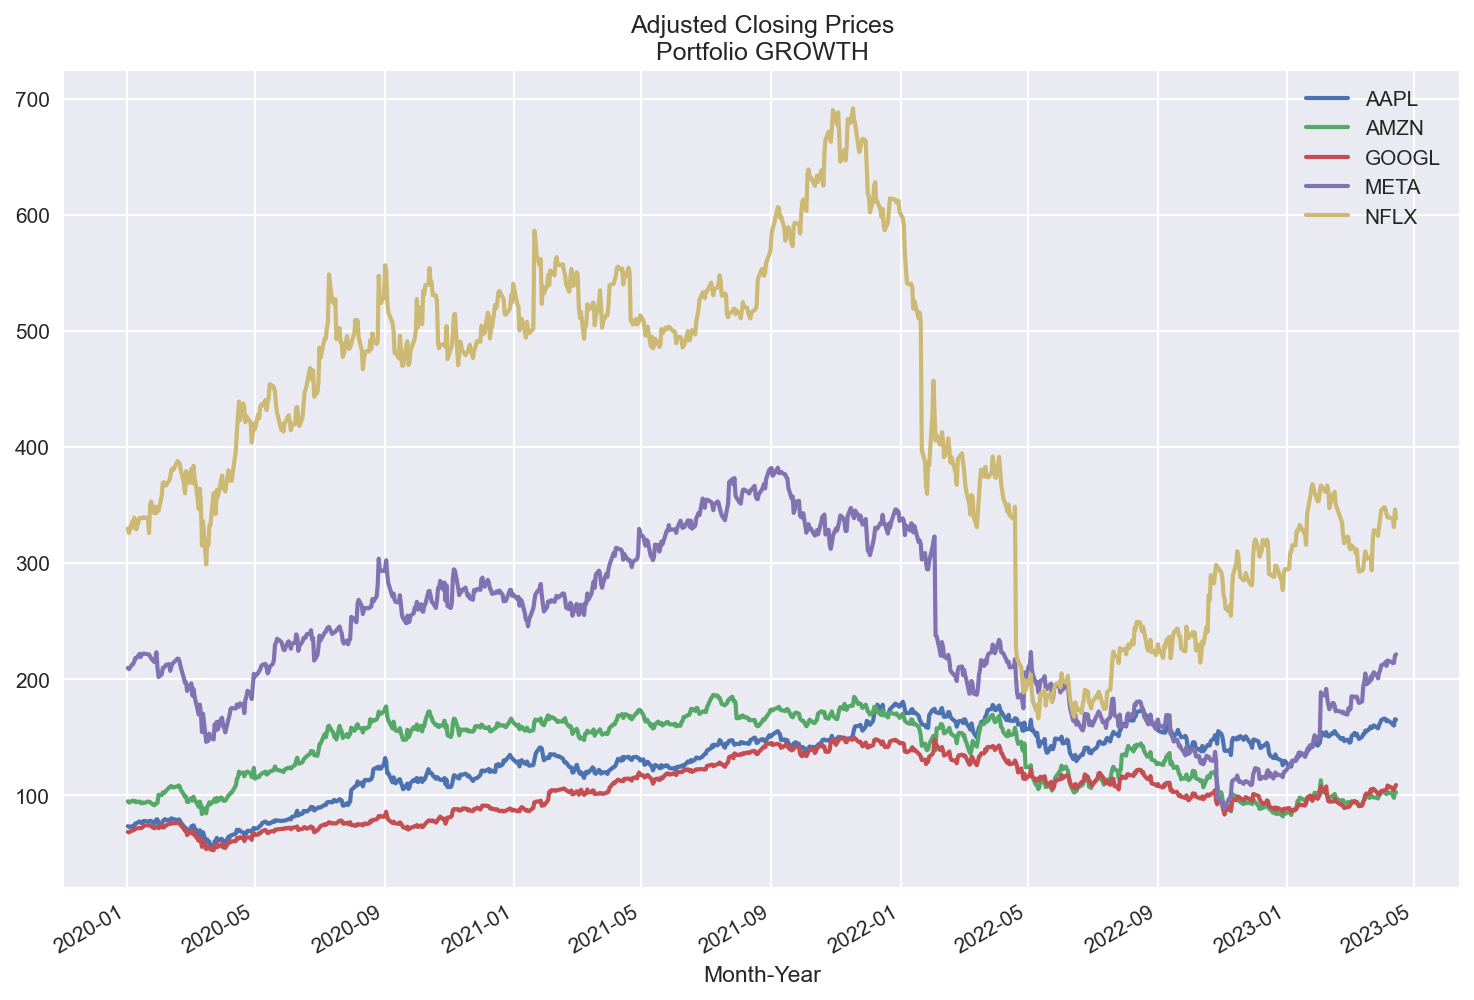

In [31]:
## Plot Nominal Stock Prices for each of the portfolios
pfo = ONE_PORTFOLIO
pfo_stock_price_df = stock_price_df[ALL_PORTFOLIOS[pfo]]['2020-01-01':]
with mpl.rc_context({'lines.linewidth': 2, 'lines.linestyle': '-'}):
    plot_data(pfo_stock_price_df, 'Adjusted Closing Prices\nPortfolio ' + pfo, 'Month-Year')

## Normalized Stock Price Movement

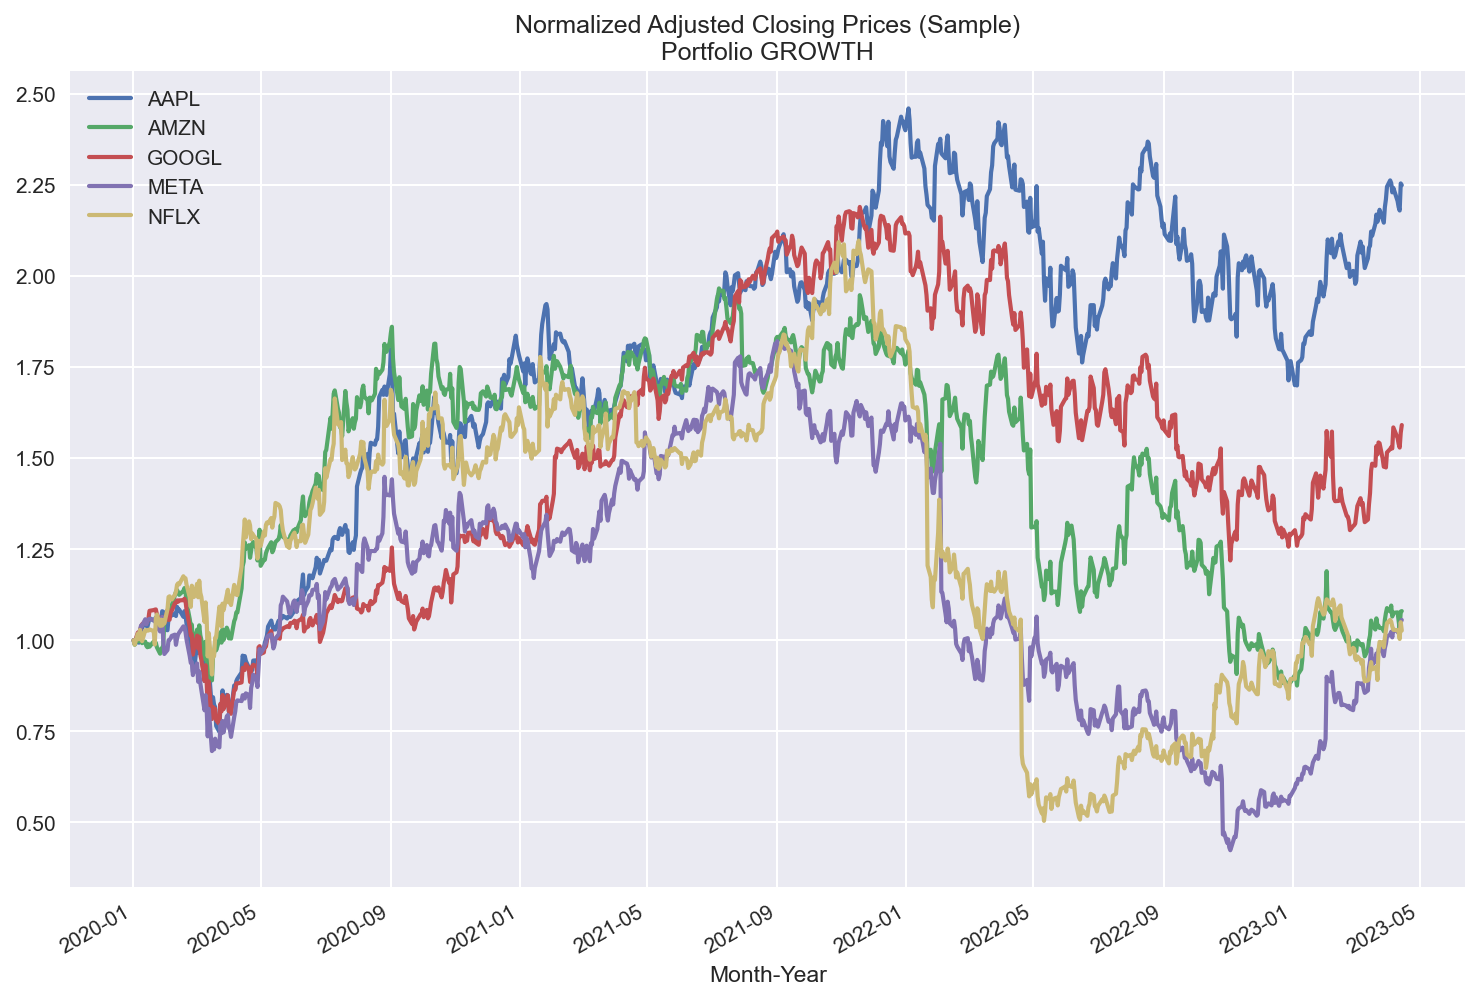

In [32]:
## Plot Normalized Stock Prices for each of the portfolios
pfo_stock_price_df = stock_price_df[ALL_PORTFOLIOS[pfo]]['2020-01-01':] 
# Plot normalized closing prices of the list of stocks
pfo_norm_price_df = normalize_price(pfo_stock_price_df)
with mpl.rc_context({'lines.linewidth': 2, 'lines.linestyle': '-'}):
    plot_data(pfo_norm_price_df, 'Normalized Adjusted Closing Prices (Sample)\nPortfolio ' + pfo, 'Month-Year')


# Daily Returns Plot

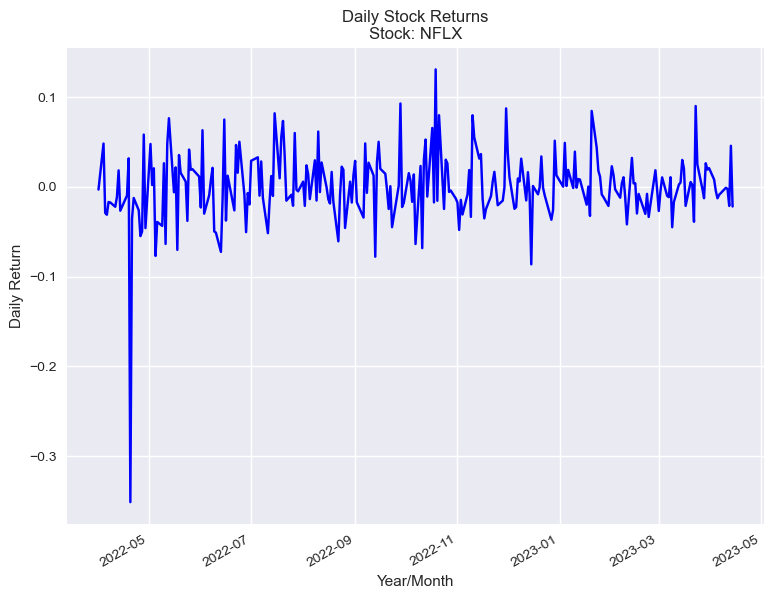

In [33]:
# Plot dialy return values
one_stock_returns['2022-04-01':].plot(figsize=(9, 7), color='blue')
plt.xlabel('Year/Month')
plt.ylabel('Daily Return')
plt.title(f'Daily Stock Returns\nStock: {ONE_STOCK_TICKER}')
plt.show();


# Bollinger Bands

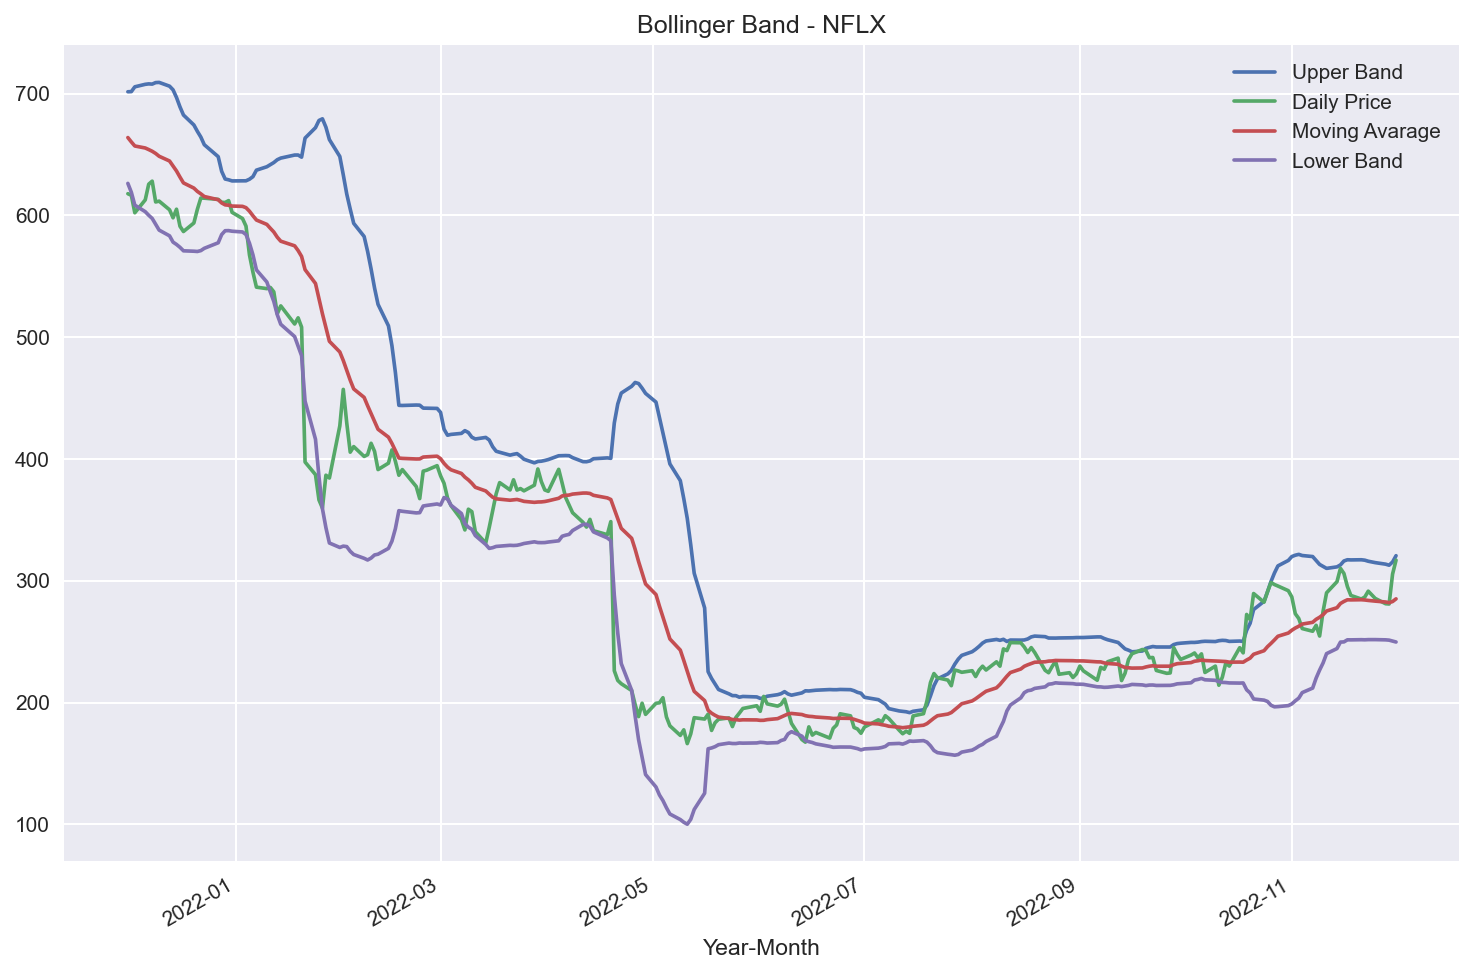

In [34]:
# Plot Bollinger Bands for one stock
plot_bollinger_bands(ONE_STOCK_TICKER, '2021-12-01', '2022-12-01') 


## Moving Averages Plot

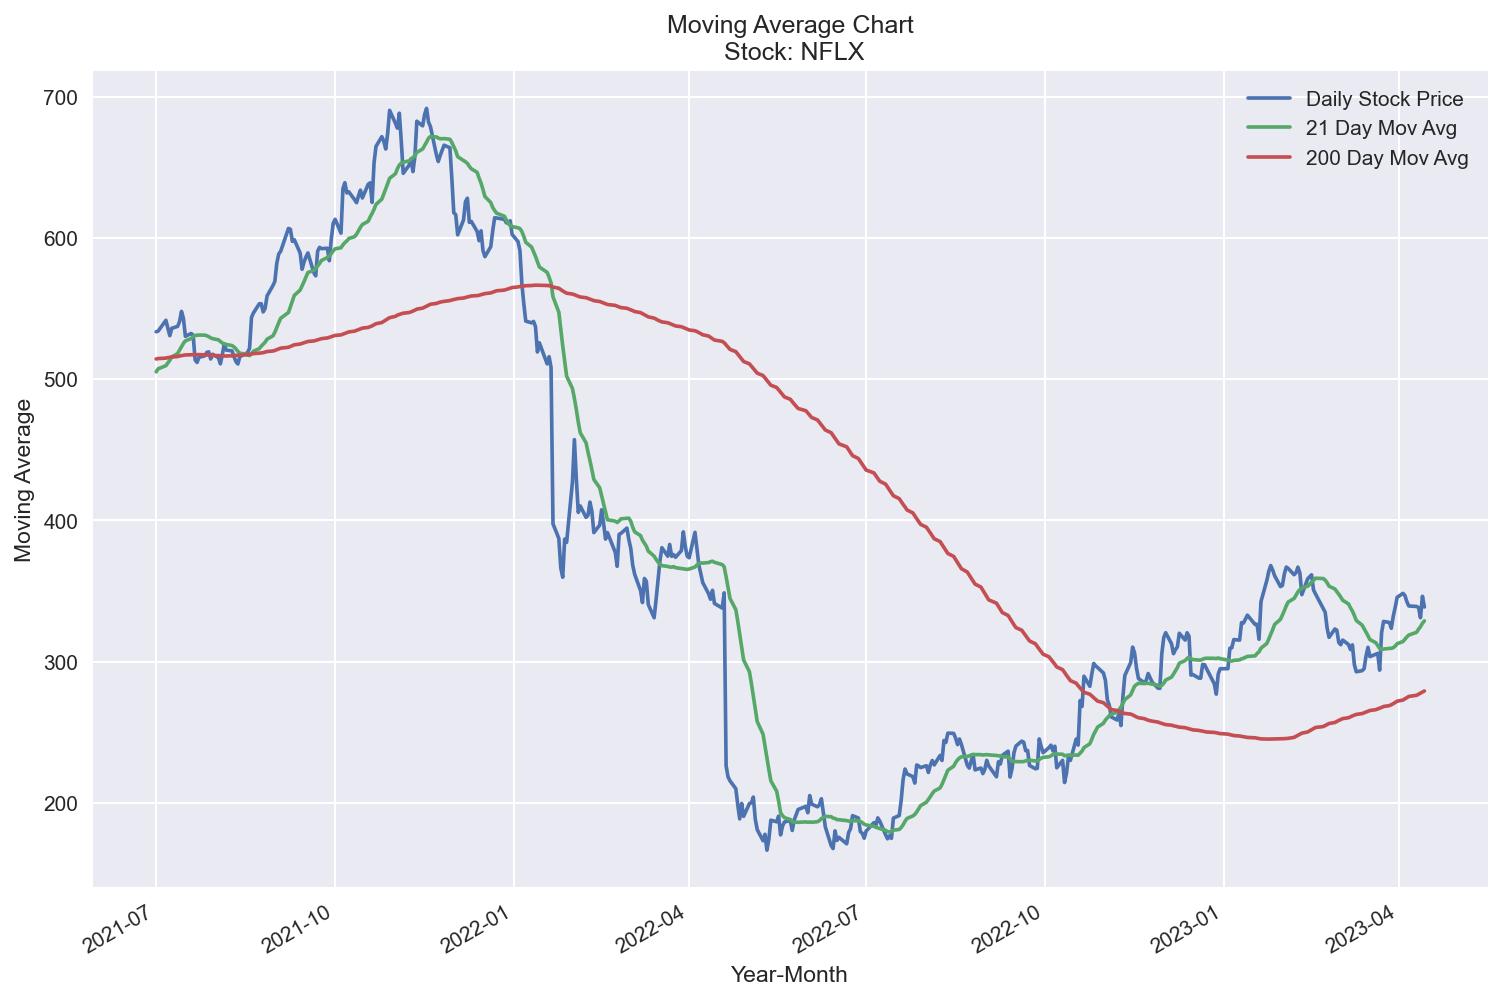

In [35]:
# Sample plot of moving averages
plot_moving_averages(ONE_STOCK_TICKER, 
                     stock_price_df, 
                     start_date='2021-07-01', 
                     end_date=END_DATE,  
                     window1=21, 
                     window2=200)

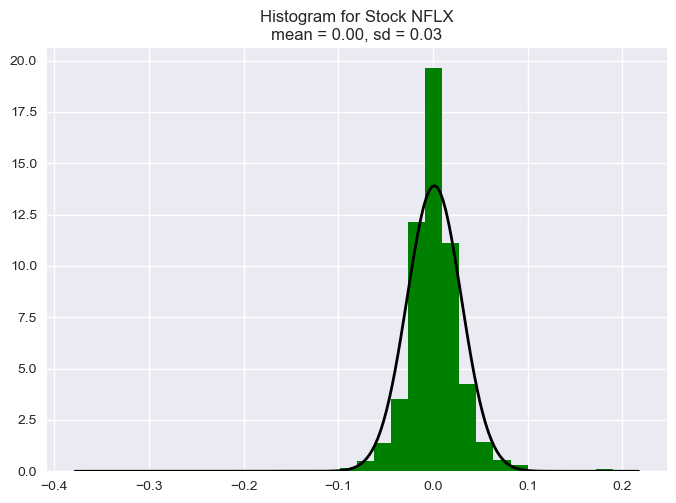

In [36]:
# Plot histogram of daily returns with Normal Discribution fitted to the data
plt.hist(one_stock_returns, bins=30, density=True, color='g')
# Fit normal distribution to the data
mu, sigma = stats.norm.fit(one_stock_returns)
# Plot the normal distribution function
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 200)
p = stats.norm.pdf(x, mu, sigma)
title = 'Histogram for Stock {}\nmean = {:.2f}, sd = {:.2f}'.format(ONE_STOCK_TICKER, mu, sigma)
plt.title(title)
plt.plot(x, p, 'k', linewidth=2)
plt.show()


## Carrelation Heatmap

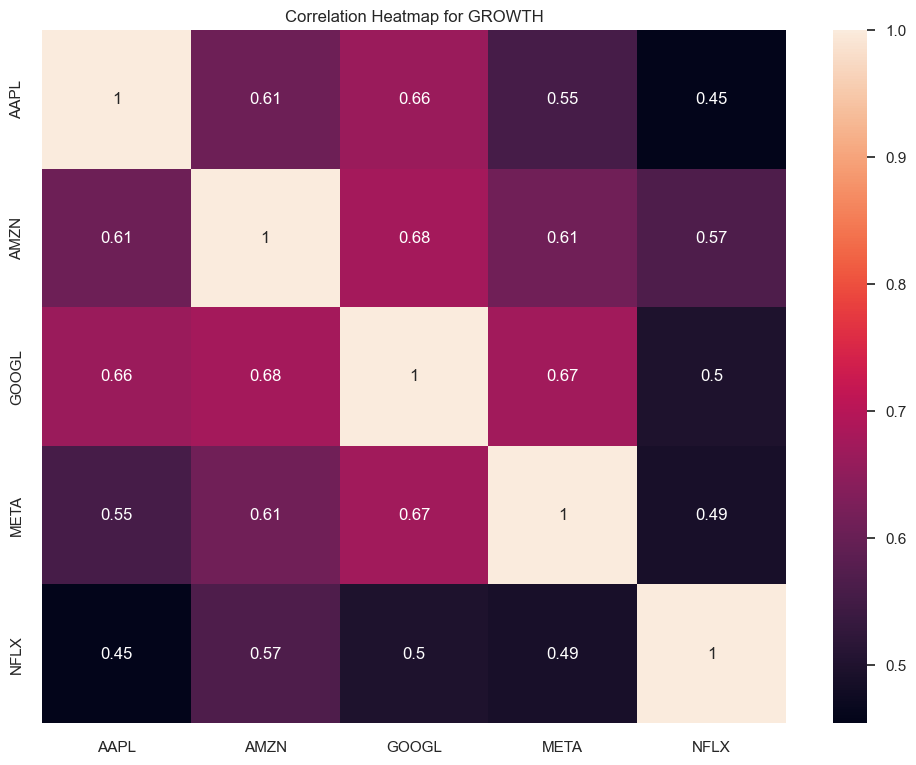

In [37]:
def plot_corr_heatmap(df, portfolio=ONE_PORTFOLIO):
    """
    Plot correlation heatmap as a grid
    """
    daily_return_corr = df[ALL_PORTFOLIOS[portfolio]].corr()
    sns.set(rc = {'figure.figsize': (12, 9)})
    ax = plt.axes()
    sns.heatmap(daily_return_corr, annot=True);
    ax.set_title('Correlation Heatmap for ' + portfolio)
    
plot_corr_heatmap(daily_return_df, ONE_PORTFOLIO)


# Data Needed for Stock Portfolio Optimization
For this simulation we will fetch ALL_SYMBOLS that constitute stocks of all the six portfolios that we are going to evaluate.

Sharpe Ratio = $\frac{{R_p} - {R_f}}{\sigma_p}$

where:
- $R_p$ is the return of the portfolio p
- $R_f$ is the risk-free return
- $\sigma_p$ is the standard deviation of the portfolio's excess return


## Data Preparation
We will fetch all stocks data, cleanse it and perform necessary data transformations. This will make the data ready for running Monte Carlo Simulation.

## Rate of Return

In [38]:
# Get daily return for all stocks

daily_return_df = stock_price_df.pct_change(periods = 1).dropna()
   

In [39]:
daily_return_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2085 entries, 2015-01-02 to 2023-04-14
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2085 non-null   float64
 1   AMZN    2085 non-null   float64
 2   ATVI    2085 non-null   float64
 3   AXP     2085 non-null   float64
 4   BAC     2085 non-null   float64
 5   BRK-B   2085 non-null   float64
 6   CAT     2085 non-null   float64
 7   COST    2085 non-null   float64
 8   CVX     2085 non-null   float64
 9   GOOGL   2085 non-null   float64
 10  GS      2085 non-null   float64
 11  HPE     2085 non-null   float64
 12  JNJ     2085 non-null   float64
 13  KO      2085 non-null   float64
 14  LOW     2085 non-null   float64
 15  MCD     2085 non-null   float64
 16  MCO     2085 non-null   float64
 17  META    2085 non-null   float64
 18  MSFT    2085 non-null   float64
 19  NEE     2085 non-null   float64
 20  NFLX    2085 non-null   float64
 21  OXY     2085 non-nu

## Normal Distribution Test
Test whether stock daily returns are normally distributed.

In [40]:
# Normal distribution test
alpha = 1e-3
reject_count = 0
non_reject_count = 0
for stock in daily_return_df['2013-03-01':'2013-03-31'].columns:
    a, b = stats.normaltest(daily_return_df[stock])
    print(f'Processing {stock}: a = {a}, b = {b}')
    if a < alpha:
        print('Null hypothesis can be rejected')
        reject_count += 1
    else:
        print('Null hypothesis cannot be rejected')
        non_reject_count += 1

print('\n\nSummary of Normal Distribution Test\n===================================')
print(f'Null hypothesis rejected ........ {reject_count}')  
print(f'Null hypothesis not rejected .... {non_reject_count}')  


Processing AAPL: a = 237.63232999887612, b = 2.504927610843254e-52
Null hypothesis cannot be rejected
Processing AMZN: a = 349.52641631213305, b = 1.2627083667012056e-76
Null hypothesis cannot be rejected
Processing ATVI: a = 736.7199648297225, b = 1.0550967450427723e-160
Null hypothesis cannot be rejected
Processing AXP: a = 853.9693061265798, b = 3.6552856143239868e-186
Null hypothesis cannot be rejected
Processing BAC: a = 398.04333282599686, b = 3.6811922382015837e-87
Null hypothesis cannot be rejected
Processing BRK-B: a = 388.6642679236687, b = 4.005221731505219e-85
Null hypothesis cannot be rejected
Processing CAT: a = 222.32872574515275, b = 5.271456415929487e-49
Null hypothesis cannot be rejected
Processing COST: a = 364.76214884416333, b = 6.207343442876177e-80
Null hypothesis cannot be rejected
Processing CVX: a = 564.6938631027864, b = 2.3893823148578384e-123
Null hypothesis cannot be rejected
Processing GOOGL: a = 327.83979861957783, b = 6.463864674755444e-72
Null hypothes

In [41]:
daily_return_df.head(3)

,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.009513,-0.005897,-0.000993,-0.000215,0.000559,-0.006527,0.003824,-0.000988,0.003566,-0.002092,0.002992,0.0,-0.000478,-0.001895,-0.015988,-0.004696,0.000835,0.005511,0.006674,0.003763,0.021457,0.000496,-0.001269,0.005778,-0.007136,-0.000535,0.008336,-0.007640,-0.002670,0.003848,-0.002625,0.000233
2015-01-05,-0.028172,-0.020517,-0.013910,-0.026446,-0.029050,-0.014547,-0.052786,-0.011369,-0.039971,-0.019054,-0.031222,0.0,-0.006984,0.000000,-0.023929,-0.011044,-0.019606,-0.016061,-0.009196,-0.010591,-0.050897,-0.037074,-0.007518,-0.005426,-0.004755,-0.018059,-0.009448,-0.017922,-0.024091,-0.008305,-0.019737,-0.002910
2015-01-06,0.000094,-0.022833,-0.018640,-0.021312,-0.029919,-0.001088,-0.006435,0.013214,-0.000463,-0.024679,-0.020230,0.0,-0.004914,0.007594,0.002270,0.001843,-0.010531,-0.013473,-0.014678,0.003884,-0.017121,-0.008499,-0.007575,0.008344,-0.004555,-0.009419,0.001490,-0.000135,-0.013257,0.010092,0.002550,0.007705


In [42]:
daily_return_df.tail(3)

,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-12,-0.004353,-0.020917,-0.001645,-0.015696,-0.008011,0.002710,-0.000453,-0.018650,0.003546,-0.006739,0.008767,-0.004361,-0.002131,0.001758,-0.007798,0.002882,-0.003809,0.000701,0.002334,0.003191,-0.021229,0.007301,-0.001968,-0.010050,0.002721,-0.004076,0.004063,-0.035794,-0.003659,-0.006337,-0.017075,-0.004864
2023-04-13,0.034104,0.046714,0.007416,0.018896,0.002809,0.011127,0.005306,0.017452,0.013367,0.026663,0.005723,0.003129,0.013360,0.007338,0.008510,0.013214,0.019183,0.029673,0.022399,0.003308,0.045796,-0.001080,0.009969,0.002417,0.004634,0.013283,0.009610,-0.001468,-0.000565,0.003061,0.002522,0.001004
2023-04-14,-0.002114,0.001074,-0.003622,0.005669,0.033613,0.005314,0.009068,-0.013236,0.002034,0.013404,0.014422,-0.007486,-0.001625,-0.001584,0.003524,-0.000311,-0.005199,0.005174,-0.012766,-0.010526,-0.021838,-0.004477,-0.004719,-0.006752,-0.005073,-0.002443,-0.001503,-0.013903,-0.011588,-0.002543,-0.012856,-0.006756


In [43]:
daily_return_df.describe()


,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
count,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000
mean,0.001086,0.001127,0.000930,0.000534,0.000524,0.000444,0.000725,0.000779,0.000570,0.000840,0.000511,0.000562,0.000396,0.000388,0.000766,0.000732,0.000755,0.000793,0.001096,0.000727,0.001348,0.000582,0.000505,0.000409,0.000429,0.000475,0.000293,0.000665,0.000175,0.000176,-0.000075,0.000443
std,0.018751,0.021085,0.020667,0.020297,0.020412,0.012794,0.019104,0.013987,0.019618,0.018045,0.018676,0.021085,0.011672,0.011726,0.018778,0.013357,0.017943,0.023974,0.017762,0.014944,0.028696,0.032387,0.012053,0.014562,0.012050,0.011677,0.014068,0.019653,0.018556,0.011711,0.018628,0.013787
min,-0.128647,-0.140494,-0.140595,-0.148187,-0.153974,-0.095921,-0.142822,-0.124513,-0.221248,-0.116341,-0.127053,-0.153144,-0.100379,-0.096725,-0.247694,-0.158754,-0.137266,-0.263901,-0.147390,-0.134171,-0.351166,-0.520138,-0.114283,-0.077346,-0.087373,-0.109424,-0.092410,-0.249303,-0.144405,-0.067352,-0.128051,-0.113758
25%,-0.007568,-0.008612,-0.008522,-0.007306,-0.009388,-0.005703,-0.008766,-0.005663,-0.008027,-0.007193,-0.008468,-0.008972,-0.004914,-0.004527,-0.007647,-0.005102,-0.006661,-0.009251,-0.006783,-0.005937,-0.012068,-0.012258,-0.004772,-0.006577,-0.004939,-0.003773,-0.006040,-0.007689,-0.007171,-0.005691,-0.008485,-0.005819
50%,0.000893,0.001143,0.000869,0.000624,0.000443,0.000406,0.000630,0.001036,0.000551,0.001072,0.000422,0.000000,0.000333,0.000491,0.001348,0.000874,0.001393,0.000892,0.000844,0.001281,0.000237,0.000000,0.000583,0.000000,0.000579,0.000538,0.000526,0.000810,0.000385,0.000177,0.000000,0.000528
75%,0.010500,0.011067,0.010856,0.008851,0.010687,0.006669,0.010568,0.007493,0.009205,0.009313,0.010256,0.010521,0.006065,0.005972,0.009605,0.006725,0.009371,0.012065,0.009967,0.007590,0.015060,0.011694,0.006140,0.007119,0.006291,0.005933,0.006851,0.009264,0.008058,0.006193,0.009087,0.006845
max,0.119808,0.141311,0.258755,0.218823,0.177962,0.116099,0.103320,0.099595,0.227407,0.162584,0.175803,0.141762,0.079977,0.064796,0.140118,0.181255,0.185717,0.232824,0.142169,0.136904,0.190281,0.336977,0.129366,0.108552,0.120090,0.090603,0.100223,0.204256,0.173679,0.076802,0.126036,0.117085


### Save Daily Returns Data into Database

In [44]:
# Connect to the SQLITE3 database
conn = sqlite3.connect(DB_NAME)

# Save merged_daily_return_df dataframe data into all_daily_return table
daily_return_df.to_sql(ALL_DAILY_RETURNS_TABLE, con=conn, if_exists='replace')


2085

## Test Read from Database

In [45]:
# Test read from the database
all_daily_returns_df = pd.read_sql('SELECT * FROM ' + ALL_DAILY_RETURNS_TABLE, con=conn, parse_dates=['Date'])

# Set index to "Date" column
all_daily_returns_df.set_index('Date', inplace=True)

In [46]:
all_daily_returns_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2085 entries, 2015-01-02 to 2023-04-14
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2085 non-null   float64
 1   AMZN    2085 non-null   float64
 2   ATVI    2085 non-null   float64
 3   AXP     2085 non-null   float64
 4   BAC     2085 non-null   float64
 5   BRK-B   2085 non-null   float64
 6   CAT     2085 non-null   float64
 7   COST    2085 non-null   float64
 8   CVX     2085 non-null   float64
 9   GOOGL   2085 non-null   float64
 10  GS      2085 non-null   float64
 11  HPE     2085 non-null   float64
 12  JNJ     2085 non-null   float64
 13  KO      2085 non-null   float64
 14  LOW     2085 non-null   float64
 15  MCD     2085 non-null   float64
 16  MCO     2085 non-null   float64
 17  META    2085 non-null   float64
 18  MSFT    2085 non-null   float64
 19  NEE     2085 non-null   float64
 20  NFLX    2085 non-null   float64
 21  OXY     2085 non-nu

In [47]:
all_daily_returns_df.head(3)

,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.009513,-0.005897,-0.000993,-0.000215,0.000559,-0.006527,0.003824,-0.000988,0.003566,-0.002092,0.002992,0.0,-0.000478,-0.001895,-0.015988,-0.004696,0.000835,0.005511,0.006674,0.003763,0.021457,0.000496,-0.001269,0.005778,-0.007136,-0.000535,0.008336,-0.007640,-0.002670,0.003848,-0.002625,0.000233
2015-01-05,-0.028172,-0.020517,-0.013910,-0.026446,-0.029050,-0.014547,-0.052786,-0.011369,-0.039971,-0.019054,-0.031222,0.0,-0.006984,0.000000,-0.023929,-0.011044,-0.019606,-0.016061,-0.009196,-0.010591,-0.050897,-0.037074,-0.007518,-0.005426,-0.004755,-0.018059,-0.009448,-0.017922,-0.024091,-0.008305,-0.019737,-0.002910
2015-01-06,0.000094,-0.022833,-0.018640,-0.021312,-0.029919,-0.001088,-0.006435,0.013214,-0.000463,-0.024679,-0.020230,0.0,-0.004914,0.007594,0.002270,0.001843,-0.010531,-0.013473,-0.014678,0.003884,-0.017121,-0.008499,-0.007575,0.008344,-0.004555,-0.009419,0.001490,-0.000135,-0.013257,0.010092,0.002550,0.007705


In [48]:
all_daily_returns_df.tail(3)

,AAPL,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,GOOGL,GS,HPE,JNJ,KO,LOW,MCD,MCO,META,MSFT,NEE,NFLX,OXY,PEP,PFE,PG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-12,-0.004353,-0.020917,-0.001645,-0.015696,-0.008011,0.002710,-0.000453,-0.018650,0.003546,-0.006739,0.008767,-0.004361,-0.002131,0.001758,-0.007798,0.002882,-0.003809,0.000701,0.002334,0.003191,-0.021229,0.007301,-0.001968,-0.010050,0.002721,-0.004076,0.004063,-0.035794,-0.003659,-0.006337,-0.017075,-0.004864
2023-04-13,0.034104,0.046714,0.007416,0.018896,0.002809,0.011127,0.005306,0.017452,0.013367,0.026663,0.005723,0.003129,0.013360,0.007338,0.008510,0.013214,0.019183,0.029673,0.022399,0.003308,0.045796,-0.001080,0.009969,0.002417,0.004634,0.013283,0.009610,-0.001468,-0.000565,0.003061,0.002522,0.001004
2023-04-14,-0.002114,0.001074,-0.003622,0.005669,0.033613,0.005314,0.009068,-0.013236,0.002034,0.013404,0.014422,-0.007486,-0.001625,-0.001584,0.003524,-0.000311,-0.005199,0.005174,-0.012766,-0.010526,-0.021838,-0.004477,-0.004719,-0.006752,-0.005073,-0.002443,-0.001503,-0.013903,-0.011588,-0.002543,-0.012856,-0.006756


## End of Notebook - Exploratory Data Analysis
